## <font color=blue>*chinook* DB Schema</font>
![chinook-schema](https://s3.amazonaws.com/dq-content/189/chinook-schema.svg)

# <font color=blue>Tips for writing complex queries<font>
-  <font color=black>Write your query in stages, and run it as you go to make sure at each stage it's producing the output you expect.</font>
-  <font color=black>If something isn't behaving as you expect, break parts of the query out into their own, separate queries to make sure there's not an inner logic error.</font>
-  <font color=black>Don't be afraid to write separate queries to check the underlying data, for instance you might write a query that you can use to manually check a calculation and give yourself confidence that the output you're seeing is correct.</font>
-  <font color=black>If you do get stuck, don't forget your support options.</font>

### <font color=blue>02 Creating Helper Functions</font>
-  <font color=black>Import the psycopg2, pandas and matplotlib modules, and use the magic command <font color=red>*%matplotlib inline*</font> to make sure any plots render in the notebook.</font>
-  <font color=black>Create a <font color=red>*run_query()*</font> function, that takes a SQL query as an argument and returns a pandas dataframe of that query.</font>
-  <font color=black>Create a <font color=red>*run_command()*</font> function that takes a SQL command as an argument and executes it using the sqlite module.</font>
-  <font color=black>Create a <font color=red>*show_tables()*</font> function that calls the <font color=red>*run_query()*</font> function to return a list of all tables and views in the database.</font>
-  <font color=black>Run the <font color=red>*show_tables()*</font> function.</font>

In [126]:
%matplotlib inline
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import security as s


# cur = conn.cursor() 

In [127]:
def run_query(query):
    with psycopg2.connect(dbname='chinook', user=s.credentials['user'], 
                          host=s.credentials['host'], password=s.credentials['password']) as conn:
        
        return pd.read_sql_query(query, conn)

def run_command(command):
    with psycopg2.connect(dbname='chinook', user=s.credentials['user'], 
                          host=s.credentials['host'], password=s.credentials['password']) as conn:
        
        conn.isolation_level = None # tells PostgreSQL to autocommit any changes
        conn.execute(command)

def show_tables():
    query = "select table_name, table_type from information_schema.tables \
                where table_type = 'BASE TABLE' AND table_schema = 'public';"
    return run_query(query)
    
def show_columns(tablename):
    query =  """select column_name from information_schema.columns where
                table_name='{tn}'""".format(tn = tablename)
    return run_query(query) 

tables = show_tables()
tables

,table_name,table_type
0,album,BASE TABLE
1,artist,BASE TABLE
2,customer,BASE TABLE
3,employee,BASE TABLE
4,genre,BASE TABLE
5,invoice,BASE TABLE
6,invoice_line,BASE TABLE
7,media_type,BASE TABLE
8,playlist,BASE TABLE
9,playlist_track,BASE TABLE


### <font color=blue>03 Selecting Albums to Purchase</font>

#### <font color=blue>Primary Question...</font>

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name | Genre |
| :----- | :----- | 
|Regal| Hip-Hop | 
|Red Tone| Punk |
|Meteor and the Girls | pop |
|ASlim Jim Bites |Blues |

#### <font color=blue>Do the following to answer the question posed above</font>

-  <font color=black>Write a query that returns each genre, with the number of tracks sold in the united states in both absolute numbers and in percentages.  Here's a list strategic of steps taken to generate this query:</font>
-  <font color=black>Create a plot to show this data.</font>
-  <font color=black>Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.  The table below</font>

In [128]:
query = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = 'USA'
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
albums_to_purchase = run_query(query)
albums_to_purchase.set_index('genre', inplace=True)

summed = albums_to_purchase.loc['Alternative & Punk','percentage_sold'] + albums_to_purchase.loc['Pop','percentage_sold'] + albums_to_purchase.loc['Blues','percentage_sold']

albums_to_purchase


,tracks_sold,percentage_sold
genre,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


The summation of the percentage of the best three choices is 0.178877259753


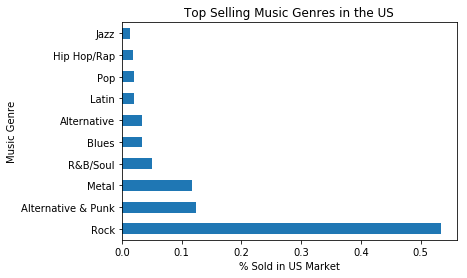

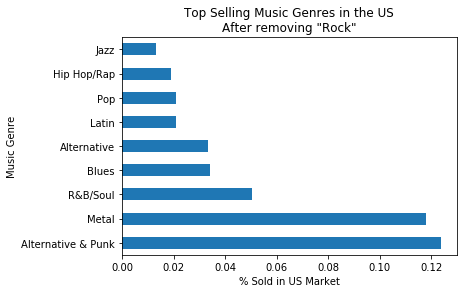

In [129]:
ax = albums_to_purchase.plot(kind='barh', y='percentage_sold', title='Top Selling Music Genres in the US')

ax.set_xlabel('% Sold in US Market')
ax.set_ylabel('Music Genre')
ax.legend_.remove()

title='Top Selling Music Genres in the US\nAfter removing "Rock"'
ax = albums_to_purchase.iloc[1:].plot(kind='barh', y='percentage_sold', title=title)
ax.set_xlabel('% Sold in US Market')
ax.set_ylabel('Music Genre')
ax.legend_.remove()

print('The summation of the percentage of the best three choices is', summed)

#### <font color=blue>Answer to Primary Question...</font>

| Artist Name | Genre |
| :----- | :----- | 
|Regal| Hip-Hop | 
|Red Tone| Punk |
|Meteor and the Girls | pop |
|ASlim Jim Bites |Blues |

*For reference, the list of artists whose albums I have to choose from are shown above.*

-  Since none of the 4 artists listed produce Rock music (which is the top selling brand in america) the plot above was reproduced without Rock music for rescaling purposes.
-  That being said the following three should be purchased: Red Tone (Punk), Meteor and the Girls (pop), and Aslim JMim Bites (blues)
-  It is worth noting that that none of the three of these are particularly good selections as their genres combined  comprise only ~ 18%.  The top selling genre (rock) makes up ~ 53% of the sales in the us.

# <font color=blue>04 Analyzing Employee Sales Performance</font>

#### <font color=blue>Background</font>

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.


#### <font color=blue>Instructions</font>

-  <font color=black>Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.</font>
-  <font color=black>Create a plot of the results of your query</font>
-  <font color=black>Write a short statement describing your results, and providing a possible interpretation.</font>


#### <font color=blue>My Thoughts</font>
-  <font color=black>For each sales agent I will check the following columns for coorleations to performance (total sales):</font>
  -  reports_to
  -  birth_date
  -  hire_date

In [130]:
query = '''
WITH emp_per AS (
    SELECT 
        e.first_name || ' ' || e.last_name Employee,
        e.reports_to Superior,
        e.birthdate birth_date,
        e.hire_date hire_date,
        SUM(i.total) Total_Sales
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY e.employee_id
    ORDER BY Total_Sales DESC)
    
SELECT
    ep.Employee,
    e.first_name || ' ' || e.last_name Superior,
    ep.birth_date,
    ep.hire_date,
    ep.Total_Sales
FROM emp_per ep
INNER JOIN employee e ON e.employee_id = ep.Superior;
'''
employee_performance = run_query(query)
employee_performance.set_index('employee', inplace=True)
employee_performance

,superior,birth_date,hire_date,total_sales
employee,,,,
Steve Johnson,Nancy Edwards,1965-03-03,2017-10-17,1393.92
Margaret Park,Nancy Edwards,1947-09-19,2017-05-03,1584.00
Jane Peacock,Nancy Edwards,1973-08-29,2017-04-01,1731.51


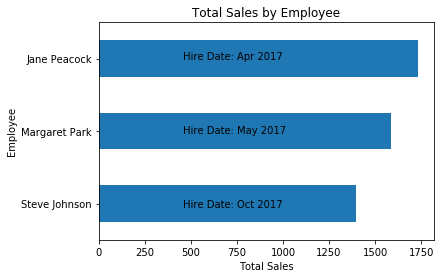

In [161]:
ax = employee_performance.plot(kind='barh', y='total_sales', title='Total Sales by Employee')

ax.set_xlabel('Total Sales')
ax.set_ylabel('Employee')
ax.legend_.remove()

#for i, label in enumerate(list(genre_sales_usa.index)):
    #score = genre_sales_usa.loc[label, "tracks_sold"]
    #label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            #).astype(int).astype(str) + "%"
    #plt.annotate(str(label), (score + 10, i - 0.15))
    
ax.annotate('Hire Date: Oct 2017', xy=(0.25, 0.15), xycoords='axes fraction')
ax.annotate('Hire Date: May 2017', xy=(0.25, 0.49), xycoords='axes fraction')
ax.annotate('Hire Date: Apr 2017', xy=(0.25, 0.83), xycoords='axes fraction')

#### <font color=blue>Answer to Question...</font>

It appers that the difference in sales relates to their hire date.

# <font color=blue>05 Analyzing Sales By Country</font>

-  Write a query that collates data on purchases from different countries. For each country, include:
  *  total number of customers
  *  total value of sales
  *  average value of sales per customer
  *  average order value
-  Where a country has only one customer, collect them into an "Other" group.
-  The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
